In [425]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
import sys
sys.path.insert(0,'/Users/eman/Documents/code_projects/kernellib/')

import matplotlib.pyplot as plt
%matplotlib inline

In [426]:
def sample_data():
    """Gets some sample data."""
    d_dimensions = 1
    n_samples = 20
    noise_std = 0.1
    seed = 123
    rng = np.random.RandomState(seed)


    n_train = 20
    n_test = 5000
    xtrain = np.linspace(-4, 5, n_train).reshape(n_train, 1)
    xtest = np.linspace(-4, 5, n_test).reshape(n_test, 1)

    f = lambda x: np.sin(x) * np.exp(0.2 * x)
    ytrain = f(xtrain) + noise_std * rng.randn(n_train, 1)
    ytest = f(xtest)

    return xtrain, xtest, ytrain, ytest

In [427]:
random_state = 0
rng = np.random.RandomState(random_state)

x_train, x_test, y_train, y_test = sample_data()

# # Training data is 11 points in [0,1] inclusive regularly spaced# Traini 
# x_train = np.linspace(0, 1, 25).reshape(-1, 1)

# # True function is sin(2*pi*x) with Gaussian noise
# y_train = np.sin(x_train * (4 * np.pi)) + rng.randn(x_train.shape[0], 1) * 0.3
# y_train = np.squeeze(y_train)

# x_test = np.linspace(0, 1, 1000).reshape(-1, 1)

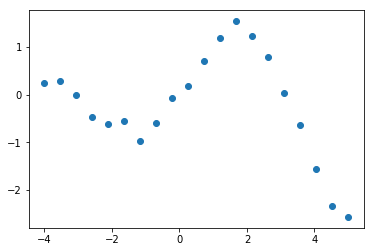

In [428]:
fig, ax = plt.subplots()

ax.scatter(x_train, y_train)

plt.show()

### RBF Kernel

In [429]:
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import rbf_kernel

## KRR with Cross Validation

In [430]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics.pairwise import check_pairwise_arrays
from sklearn.linear_model.ridge import _solve_cholesky_kernel
from sklearn.utils import check_array, check_X_y
from sklearn.utils.validation import check_is_fitted
from sklearn.kernel_ridge import KernelRidge

In [431]:
from sklearn.model_selection import GridSearchCV

In [432]:
print(np.logspace(0, 10, 10))

[1.00000000e+00 1.29154967e+01 1.66810054e+02 2.15443469e+03
 2.78255940e+04 3.59381366e+05 4.64158883e+06 5.99484250e+07
 7.74263683e+08 1.00000000e+10]


In [433]:
%%time
krr_grid = GridSearchCV(KernelRidge(kernel='rbf'), cv=2, n_jobs=2,
                  param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3],
                              "gamma": np.logspace(-3, 3, 20)})
krr_grid.fit(x_train, y_train)
krr_model = krr_grid.best_estimator_

print(krr_model.gamma, krr_model.alpha)

weights = krr_model.dual_coef_
gamma = krr_model.gamma
alpha = krr_model.alpha
K = rbf_kernel(x_test, x_train, gamma=gamma)

y_pred = krr_model.predict(x_test)

0.1623776739188721 0.01
CPU times: user 105 ms, sys: 122 ms, total: 227 ms
Wall time: 418 ms


# Full Derivative Map

[Nx dx] = size(x);
[Ns ds] = size(sv);
Kreg = kernel2(x,sv,sigma);
% for p=1:Nx
%     for q=1:Ns
%         for xxx = 1:dx
%             map0(xxx,p,q) = alpha(q) * (x(p,xxx)-sv(q,xxx)) * Kreg(p,q);
%         end
%     end
% end

map2 = zeros(dx,Nx,Ns);
for p=1:Nx
        map2(:,p,:) = (repmat(alpha,1,size(sv,2)) .* (repmat(x(p,:),size(sv,1),1)-sv) .* repmat(Kreg(p,:)',1,size(sv,2)))';
        %p
end

In [434]:
import sys
sys.path.insert(0, '/home/emmanuel/Drives/erc/code/kernellib')

from kernellib.derivatives import ard_derivative

In [435]:
print(np.ndim(x_test))

2


## Pure Python

In [436]:
def rbf_full_py(x_train, x_function, K, weights, gamma):
    
    n_test, d_dims = x_function.shape
    n_train, d_dims = x_train.shape
    
    derivative = np.zeros(shape=(n_test, n_train, d_dims))
    
    constant = - 2* gamma
    for itest in range(n_test):
        for itrain in range(n_train):
            for idim in range(d_dims):
                derivative[itest, itrain, idim] = \
                    weights[itrain] \
                    * (x_function[itest, idim] - x_train[itrain, idim]) \
                    * K[itest, itrain]
    
    derivative *= constant
    
    return derivative

In [437]:
d1_map_py = rbf_full_py(x_train, x_test, K, weights, gamma)
d1_der_py = d1_map_py.sum(axis=1)
print(d1_der_py.shape)

(5000, 1)


In [438]:
pyed = %timeit -o rbf_full_py(x_train, x_test, K, weights, gamma)

392 ms ± 31.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


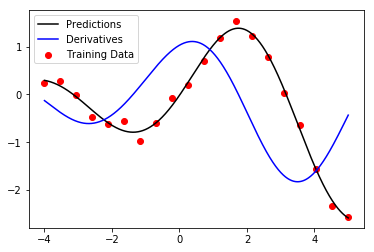

In [439]:
fig, ax = plt.subplots()

ax.scatter(x_train, y_train, color='r', label='Training Data')
ax.plot(x_test, y_pred, color='k', label='Predictions')
ax.plot(x_test, d1_der_py, color='b', label='Derivatives')

ax.legend()
plt.show()

#### Check Gradient

In [197]:
from scipy.optimize import check_grad, approx_fprime

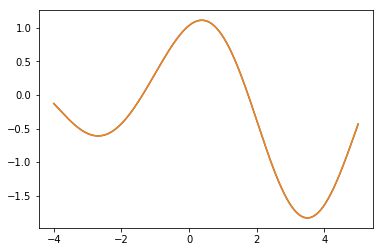

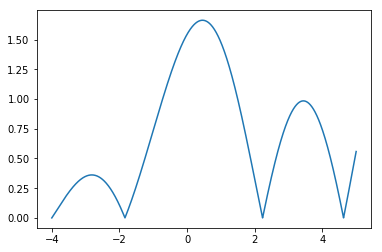

In [198]:
def my_grad(X):
    full_d = rbf_full_py(x_train, X.reshape(-1,1), K, weights, gamma)
    d1 = full_d.sum(axis=1).flatten()
    return d1

def my_pred(X):
    pred = krr_model.predict(X.reshape(-1, 1)).flatten()
    return pred.flatten()

d1_numerical = list()
for i in x_test:
    d1_numerical.append(approx_fprime(i, my_pred, [eps]))

d1_numerical = np.array(d1_numerical)
eps = np.sqrt(np.finfo(float).eps)

x = np.linspace(0, 1, 100)

errs = list()
for i in x_test:
    
    errs.append(check_grad(my_pred, my_grad, i))

    
fig, ax = plt.subplots()

ax.plot(x_test, d1_numerical)
ax.plot(x_test, d1_der_py)
plt.show()

fig, ax = plt.subplots()

ax.plot(x_test, np.array(errs))

plt.show()

## Numpy

In [199]:
def rbf_full_numpy(x_train, x_function, K, weights, gamma):

    n_test, d_dims = x_function.shape
    n_train, d_dims = x_train.shape
    derivative = np.zeros(shape=(n_test, n_train, d_dims))
    
    constant = -2*gamma
    
    for itest in range(n_test):
        term1 = (np.tile(x_function[itest, :], (n_train, 1)) - x_train)
        term2 = np.tile(weights, (1, d_dims))
        term3 = np.tile(K[itest, :].T, (1, d_dims)).T
        derivative[itest, :, :] = term1 * term2 * term3\

    derivative *= constant
    return derivative

In [200]:
d1_map_np = rbf_full_numpy(x_train, x_test, K,  weights, gamma)

In [210]:
npyed = %timeit -o rbf_full_numpy(x_train, x_test, K, weights, gamma)

78 ms ± 8.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [215]:
print('Numpy Speed up: ', pyed.best / npyed.best)

Numpy Speed up:  5.473331135328124


In [205]:
np.testing.assert_array_equal(d1_map_py, d1_map_np)

## Numba

In [471]:
import numba
from numba import njit, jit, prange, double

In [472]:
K = rbf_kernel(x_test, x_train, gamma=gamma)
weights = krr_model.dual_coef_

In [473]:
import numba


@njit(fastmath=True)
def rbf_full_numba(x_train, x_function, K, weights, gamma):
    
    n_test, d_dims = x_function.shape
    n_train, d_dims = x_train.shape
    
    derivative = np.zeros(shape=(n_test, n_train, d_dims))
    
    for idim in prange(d_dims):
        for itrain in range(n_train):
            w = weights[itrain]
            for itest in range(n_test):      
#                 print(weights.shape)
                derivative[itest, itrain, idim] = \
                     w * (x_function[itest, idim] - x_train[itrain, idim]) * K[itest, itrain]
    
    derivative *= - 2 * gamma
    
    return derivative

In [474]:
d1_map_numba = rbf_full_numba(x_train, x_test, K, weights.flatten(), gamma)

In [475]:
jitted = %timeit -o rbf_full_numba(x_train, x_test, K, weights.flatten(), gamma)

807 µs ± 63.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [476]:
print('Jitted Speed up (Numpy): ', npyed.best / jitted.best)
print('Numba Speed up (Python): ', pyed.best / jitted.best)

Jitted Speed up (Numpy):  87.12118554565923
Numba Speed up (Python):  464.53758692055965


In [477]:
np.testing.assert_array_equal(d1_map_py, d1_map_numba)

# Derivative

## Pure Python

In [221]:
def rbf_derivative_py(x_train, x_function, weights, gamma):
    if np.ndim(x_function) == 1:
        x_function = x_function[np.newaxis, :]
    if np.ndim(weights) == 1:
        weights = weights[:, np.newaxis]
    n_test, d_dims = x_function.shape
    n_train, d_dims = x_train.shape
    derivative = np.zeros(shape=(n_test, n_train, d_dims))
    
    K = rbf_kernel(x_function, x_train, gamma=gamma)
    constant = -2*gamma
    
    for itest in range(n_test):
        term1 = (np.tile(x_function[itest, :], (n_train, 1)) - x_train)
        term2 = np.tile(weights, (1, d_dims))
        term3 = np.tile(K[itest, :].T, (1, d_dims)).T
        derivative[itest, :, :] = term1 * term2 * term3\

    derivative *= constant
    derivative = np.sum(derivative, axis=1)
    return derivative

In [222]:
d1_der_py = rbf_derivative_py(x_train, x_test, weights, gamma)

In [223]:
pyedd = %timeit -o rbf_derivative_py(x_train, x_test, weights, gamma)

73.2 ms ± 7.64 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Numpy

In [297]:
def rbf_derivative_np(x_train, x_function, K, weights, gamma):
    
#     # check the sizes of x_train and x_test
#     err_msg = "xtrain and xtest d dimensions are not equivalent."
#     np.testing.assert_equal(x_function.shape[1], x_train.shape[1], err_msg=err_msg)
    
#     # check the n_samples for x_train and weights are equal
#     err_msg = "Number of training samples for xtrain and weights are not equal."
#     np.testing.assert_equal(x_train.shape[0], weights.shape[0], err_msg=err_msg)

    
    
    n_test, n_dims = x_function.shape

    derivative = np.zeros(shape=x_function.shape)
    
    for itest in range(n_test):
        derivative[itest, :] = np.dot((x_function[itest, :] - x_train).T,  
                                      (K[itest, :].reshape(-1, 1) * weights))

    derivative *= - 2 * gamma
        
    return derivative

In [298]:
# K = pairwise_kernels(x_function, x_train, gamma=gamma, metric='rbf')
K = rbf_kernel(x_test, x_train, gamma=gamma)
weights = krr_model.dual_coef_.reshape(-1, 1)

d1_der_np = rbf_derivative_np(x_train, x_test, K, weights, gamma)

In [304]:
np.testing.assert_array_almost_equal(d1_der_py, d1_der_np, decimal=12)

In [301]:
npyedd = %timeit -o rbf_derivative_np(x_train, x_train, K, weights, gamma)

98.5 µs ± 6.4 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [302]:
print('Numpy Speed up: ', pyedd.best / npyedd.best)

Numpy Speed up:  695.097790585193


#### Version II

In [287]:
# def rbf_derivative_np2(x_train, x_function, K, weights, gamma):
    
# #     # check the sizes of x_train and x_test
# #     err_msg = "xtrain and xtest d dimensions are not equivalent."
# #     np.testing.assert_equal(x_function.shape[1], x_train.shape[1], err_msg=err_msg)
    
# #     # check the n_samples for x_train and weights are equal
# #     err_msg = "Number of training samples for xtrain and weights are not equal."
# #     np.testing.assert_equal(x_train.shape[0], weights.shape[0], err_msg=err_msg)

    
    
#     n_test, n_dims = x_function.shape

#     derivative = np.zeros(shape=x_function.shape)

#     constant = - 2 * gamma
# #     print(x_train.T.shape)
# #     print(np.diag(weights.flatten()).shape, K.T.shape)
# #     print(weights.T.shape, K.T.shape)
#     derivative = x_train.T.dot(np.diag(weights.flatten()).dot(K.T) - np.diag(weights.T.dot(K.T))).T

#     derivative *= constant
        
#     return derivative

In [288]:
d1_der_np2 = rbf_derivative_np2(x_train, x_train, K, weights, gamma)

In [289]:
npyedd2 = %timeit -o rbf_derivative_np2(x_train, x_train, K, weights, gamma)

185 µs ± 6.82 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [290]:
print('Numpy2 Speed up: ', pyedd.best / npyedd2.best)

Numpy2 Speed up:  361.86849062941303


In [291]:
np.testing.assert_almost_equal(d1_der_py, d1_der_np2, decimal=3)

AssertionError: 
Arrays are not almost equal to 3 decimals

(mismatch 99.96%)
 x: array([-0.129, -0.13 , -0.131, ..., -0.439, -0.436, -0.434])
 y: array([1.471, 1.472, 1.472, ..., 5.593, 5.593, 5.593])

## Numba

In [478]:
@njit(fastmath=True)
def rbf_derivative_numba(x_train, x_function, K, weights, gamma):
    
#     # check the sizes of x_train and x_test
#     err_msg = "xtrain and xtest d dimensions are not equivalent."
#     np.testing.assert_equal(x_function.shape[1], x_train.shape[1], err_msg=err_msg)
    
#     # check the n_samples for x_train and weights are equal
#     err_msg = "Number of training samples for xtrain and weights are not equal."
#     np.testing.assert_equal(x_train.shape[0], weights.shape[0], err_msg=err_msg)

    
    
    n_test, n_dims = x_function.shape

    derivative = np.zeros(shape=x_function.shape)

    constant = - 2 * gamma
    
    for itest in prange(n_test):
        derivative[itest, :] = np.dot((x_function[itest, :] - x_train).T,  
                                      (K[itest, :].reshape(-1, 1) * weights))

    derivative *= constant
        
    return derivative

In [479]:
d1_der_nmb = rbf_derivative_numba(x_train, x_test, K, weights, gamma)
np.testing.assert_array_almost_equal(d1_der_py, d1_der_nmb, decimal=10)

In [480]:
jittedd = %timeit -o rbf_derivative_numba(x_train, x_train, K, weights, gamma)

15.9 µs ± 509 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [481]:
print('Numpy Speed up: ', npyedd.best / jittedd.best)
print('Python Speed up: ', pyedd.best / jittedd.best)

Numpy Speed up:  6.070084974227466
Python Speed up:  4219.30265424989


# 2nd Map Derivative

$$\frac{\partial^2f}{x^2}=2\gamma \left[2 \gamma( x^j - y^j )^2 - 1  \right] K(x,y)$$

## Pure Python

In [482]:
def rbf_full2_py(x_train, x_function, K, weights, gamma):
    
    n_test, d_dims = x_function.shape
    n_train, d_dims = x_train.shape
    
    derivative = np.zeros(shape=(n_test, n_train, d_dims))
    
    constant = 2* gamma
    for itest in range(n_test):
        for itrain in range(n_train):
            for idim in range(d_dims):
                derivative[itest, itrain, idim] = \
                    weights[itrain, 0] \
                    * (constant * (x_function[itest, idim] - x_train[itrain, idim])**2 - 1) \
                    * K[itest, itrain]
    
    derivative *= constant
    
    return derivative

In [483]:
d2_map_py = rbf_full2_py(x_train, x_test, K, weights, gamma)
d2_der_py = d2_map_py.sum(axis=1)
print(d2_der_py.shape)

(5000, 1)


In [484]:
pyed2 = %timeit -o rbf_full2_py(x_train, x_test, K, weights, gamma)

173 ms ± 15.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


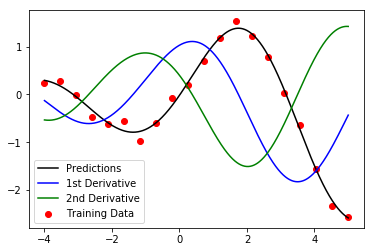

In [485]:
fig, ax = plt.subplots()

ax.scatter(x_train, y_train, color='r', label='Training Data')
ax.plot(x_test, y_pred, color='k', label='Predictions')
ax.plot(x_test, d1_der_py, color='b', label='1st Derivative')
ax.plot(x_test, d2_der_py, color='g', label='2nd Derivative')


ax.legend()
plt.show()

## Numpy

In [486]:
def rbf_full2_numpy(x_train, x_function, K, weights, gamma):

    n_test, d_dims = x_function.shape
    n_train, d_dims = x_train.shape
    derivative = np.zeros(shape=(n_test, n_train, d_dims))
    
    constant = 2*gamma
    
    term2 = np.tile(weights, (1, d_dims))
    
    for itest in range(n_test):
        
        term1 = constant * (np.tile(x_function[itest, :], (n_train, 1)) - x_train)**2 - 1
#         print(term1.shape)
        
#         print(term2.shape)
        term3 = np.tile(K[itest, :].T, (1, d_dims)).T
#         print(term3.shape)
        derivative[itest, :, :] = term1 * term2 * term3
#         break

    derivative *= constant
    return derivative

In [487]:
d2_map_np = rbf_full2_numpy(x_train, x_test, K,  weights, gamma)

In [488]:
npyed2 = %timeit -o rbf_full2_numpy(x_train, x_test, K, weights, gamma)

85.5 ms ± 12.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [489]:
print('Numpy Speed up: ', pyed2.best / npyed2.best)

Numpy Speed up:  2.1434430050232196


In [490]:
np.testing.assert_array_almost_equal(d2_map_py, d2_map_np)

## Numba

In [509]:
@njit(fastmath=True)
def rbf_full2_numba(x_train, x_function, K, weights, gamma):
    
    n_test, d_dims = x_function.shape
    n_train, d_dims = x_train.shape
    
    derivative = np.zeros(shape=(n_test, n_train, d_dims))
    
    constant = 2* gamma
    for idim in range(d_dims):
        for itrain in range(n_train):
            for itest in prange(n_test):
                derivative[itest, itrain, idim] = \
                     weights[itrain]\
                    * (constant * (x_function[itest, idim] - x_train[itrain, idim])**2 - 1) \
                    * K[itest, itrain]
    
    derivative *= constant
    
    return derivative

In [510]:
d2_map_numba = rbf_full2_numba(x_train, x_test, K,  weights.flatten(), gamma)

In [511]:
jitted2 = %timeit -o rbf_full2_numba(x_train, x_test, K, weights.flatten(), gamma)

787 µs ± 35.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [512]:
print('Python Speed up: ', pyed2.best / jitted2.best)
print('Numpy Speed up: ', npyed2.best / jitted2.best)

Python Speed up:  205.34268751987753
Numpy Speed up:  95.80039545658602
